# Title

# Introduction

For this project, we want to solve the question, “Given a certain temperature and absolute magnitude, what type of star do we have?” This is a classification problem, specifically for determining star type, whether a star is a Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence, Super Giant or Hyper Giant according to the temperature and the absolute magnitude. Absolute magnitude (M) is a measure of the luminosity of a celestial object: it measures the star’s luminosity at a distance of 32.6 light years, ensuring the measurements are all standard and relative to each other. The energy inside a star increases from Red Dwarf to Hyper Giants. Therefore, each type of star has its own specific properties including a temperature range and a range of absolute magnitude. We want to look at how we can use these two star properties to predict what type a star could be. We will be using a dataset from Kaggle called “Star Type Classification / NASA”. There are 240 observations in the dataset, 4 quantitative variables (Temperature, Luminosity, Solar Radius, Absolute Magnitude) and 3 qualitative variables (Color, Spectral Class, Type), we will choose temperature and absolute magnitude as our variables to predict star type.

# Methods and Results

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

***Method & Results***

In our project, we are using classification model to predict the type of the stars (`Type`) based on two predictors: Temperature(K) (`Temperature`) and Absolute Magnitude (`A_M`). In our dataset, the type of stars is represented by 0, 1, 2, 3, 4, 5, where 0 = Red Dwarf, 1 = Brown Dwarf, 2 = White Dwarf, 3 = Main Sequence, 4 = Super Giants, 5 = Hyper Giants.

First, we need to load data from the original source on the web using `read_csv` function, and we name the dataset `Stars`. We can have a look of our dataset using `head` function.

In [11]:
Stars <- read_csv("https://raw.githubusercontent.com/yclllll/stars-set/main/Stars.csv")
head(Stars)

Parsed with column specification:
cols(
  Temperature = col_double(),
  L = col_double(),
  R = col_double(),
  A_M = col_double(),
  Color = col_character(),
  Spectral_Class = col_character(),
  Type = col_double()
)



Temperature,L,R,A_M,Color,Spectral_Class,Type
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
3068,0.002400,0.1700,16.12,Red,M,0
3042,0.000500,0.1542,16.60,Red,M,0
2600,0.000300,0.1020,18.70,Red,M,0
2800,0.000200,0.1600,16.65,Red,M,0
1939,0.000138,0.1030,20.06,Red,M,0
2840,0.000650,0.1100,16.98,Red,M,0


As we can see, we have seven columns in the dataset, but we only need three of them, which are `Temperature`, `A_M`, and `Type`. Thus, we need to wrangle and clean the data from it's original (downloaded) format to the format necessary for the planned analysis. To clean our data, we will use `select` function to choose the columns we need and make the data into a new data called `stars`, and then we will convert `Type` from double to factor using `as_factor` function since `Type` is the target that we will predict in this project. We can have a look of our new data using `head` function again. 

In [12]:
stars <- Stars %>%
select(Temperature, A_M, Type) %>%
mutate(Type = as_factor(Type))

head(stars)

Temperature,A_M,Type
<dbl>,<dbl>,<fct>
3068,16.12,0
3042,16.60,0
2600,18.70,0
2800,16.65,0
1939,20.06,0
2840,16.98,0


We can summarize our new data by using the `summary()` function to find the statistics for each column. We named the summary of data `star_summary`.

In [13]:
star_summary <- summary(stars)
star_summary

  Temperature         A_M          Type  
 Min.   : 1939   Min.   :-11.920   0:40  
 1st Qu.: 3344   1st Qu.: -6.232   1:40  
 Median : 5776   Median :  8.313   2:40  
 Mean   :10497   Mean   :  4.382   3:40  
 3rd Qu.:15056   3rd Qu.: 13.697   4:40  
 Max.   :40000   Max.   : 20.060   5:40  

Then, we will visualize our data `stars` by a scatter plot. We call this plot `star_plot`. We use `ggplot` and `geom_point` to make a scatter plot, and we use `xlab` and `ylab` to label the x-axis and y-axis. We can also label the legend use `labs` function. `ggtitle` gives a title to the plot. `options` function is used to decide the size of the plot and `theme` function is used to determine the font size. 

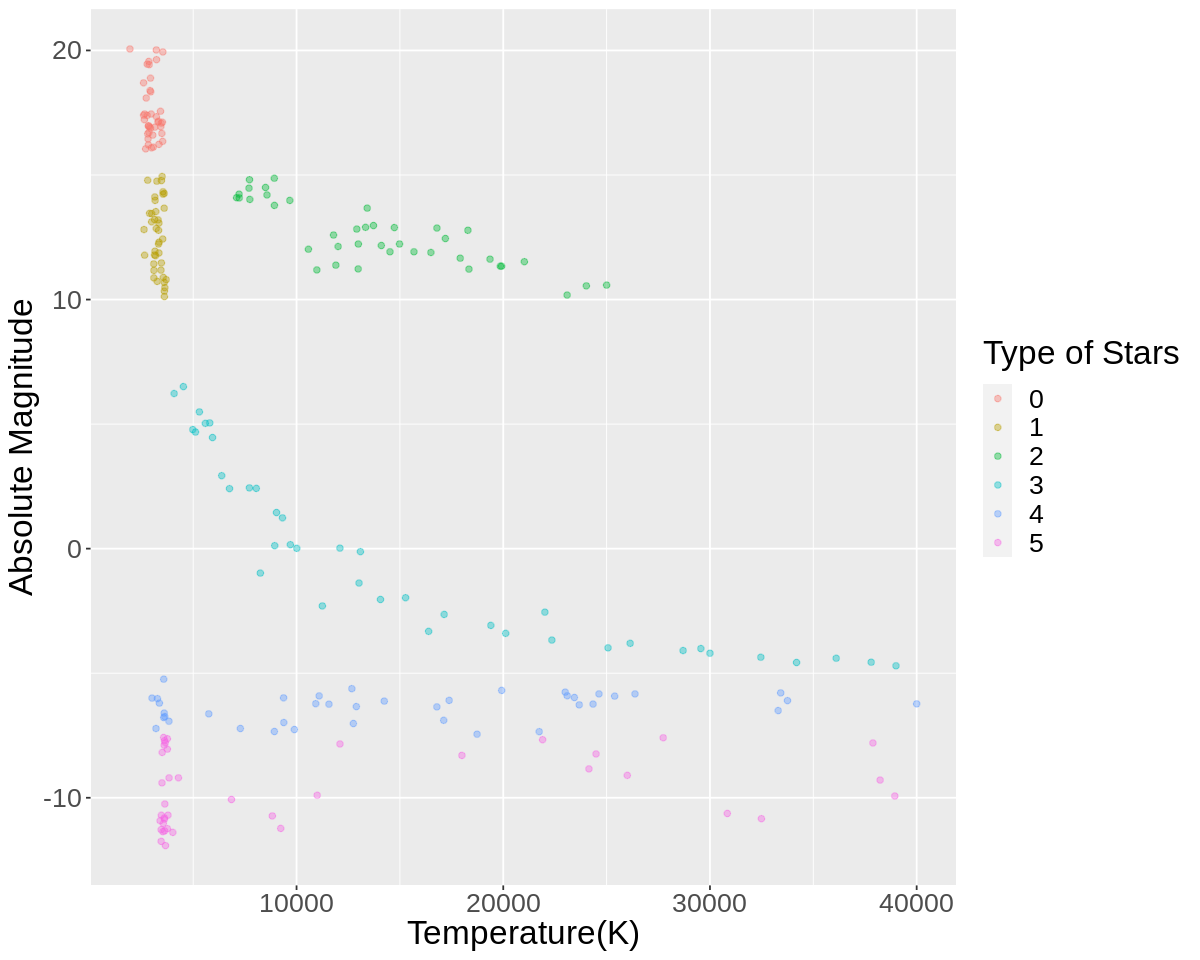

In [14]:
options(repr.plot.width = 10, repr.plot.height = 8)

star_plot <- stars %>%
ggplot(aes(x = Temperature, y = A_M, color = Type)) +
geom_point(alpha = 0.4) +
xlab("Temperature(K)") +
ylab("Absolute Magnitude")+
labs(color = "Type of Stars") +
theme(text = element_text(size = 20)) 

star_plot

After that, we will start analyzing the data using classification model. First, we split `stars` data into training data and testing data using `initial_split` function. We want to use 75% of the data as training data, and we use `prop` to set this. For the `strata` argument, we place the variable we want to classify, `Type`. We call the training set `star_training` and the testing set `star_testing`.

In [15]:
star_split <- initial_split(stars, prop = 0.75, strata = Type)
star_training <- training(star_split)
star_testing <- testing(star_split)

head(star_training)
head(star_testing)

Temperature,A_M,Type
<dbl>,<dbl>,<fct>
3068,16.12,0
3042,16.60,0
2800,16.65,0
1939,20.06,0
2840,16.98,0
2637,17.22,0


Temperature,A_M,Type
<dbl>,<dbl>,<fct>
2600,18.70,0
2700,16.05,0
2799,14.79,1
3692,10.80,1
3192,13.53,1
16500,11.89,2


Next, we will create the recipe using `recipe` function and `stars_training` data. We also need to standardize our training data since K-nearest neighbors is sensitive to the scale of the predictors. We first pass the target variable `Type` and predictors `Temperature` and `A_M` to the `recipe` function. To scale the predictors, we use `step_scale(all_predictors())` function; to center the predictors, we use `step_center(all_predictors())` function.

In [16]:
star_recipe <- recipe(Type ~ Temperature + A_M, data = star_training) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

star_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

So far, we have split the training and testing datasets as well as preprocessed the data. Then, we will pick the best number of neighbors *K* to build the model. We want to use 5-fold-cross-validation to get a better estimate of accuracy, which will lead to a better choice of the number of neighbours *K* for the overall set of training data. In 5-fold-cross-validation, we split our overall training data into 5 evenly-sized chunks, and then iteratively use 1 chunk as the validation set and combine the remaining 5−1 chunks as the training set. To perform this, we use `vfold_cv` function. In the function, we identify the training set `stars_training`, the number of folds `v` = 5, and the `strata` argument is `Type`.  

In [17]:
star_vfold <- vfold_cv(star_training, v = 5, strata = Type)

Using a 5-fold cross-validation, we have established a prediction accuracy for our classifier. Then we want to create a *K*-nearest neighbor model specification. In the specification, we use `tune()` to let each parameter in the model can be adjusted rather than given a specific value. We call the model specification `star_spec`.

In [18]:
star_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

star_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Then we create a `workflow()` analysis that combines `star_recipe` and `star_spec` model specification. In the workflow, we will use `tune_grid` function to fit the model for each value in a range of parameter values. For the `resamples` argument, input the `star_vfold` model we created earlier. The `grid` argument specifies that the tuning should try *X* amount of values of the number of neighbors *K* when tuning. In this project, we use number of neighbors from 1 to 50. Finally, we use `collect_metrics()` to  aggregate the mean and standard error. We call this workflow analysis `star_results`.

In [19]:
gridvals <- tibble(neighbors = seq(from = 1, to = 50))

star_results <- workflow() %>%
add_recipe(star_recipe) %>%
add_model(star_spec) %>%
tune_grid(resamples = star_vfold, grid = gridvals) %>%
collect_metrics()

head(star_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9555556,5,0.011111111,Model01
1,roc_auc,hand_till,0.9733333,5,0.006666667,Model01
2,accuracy,multiclass,0.9555556,5,0.011111111,Model02
2,roc_auc,hand_till,0.9876852,5,0.003734249,Model02
3,accuracy,multiclass,0.9388889,5,0.016197089,Model03
3,roc_auc,hand_till,0.9850926,5,0.004042385,Model03


Now, we can find the best value of the number of neighbors based on `star_results`. We first filter for `accuracy` from the `.metric` column, we call the dataset `accuracies`. Then, we create a line plot using the `accuracies` dataset with `neighbors` on the x-axis and the `mean` on the y-axis. We call the plot `accuracy_vs_k`.

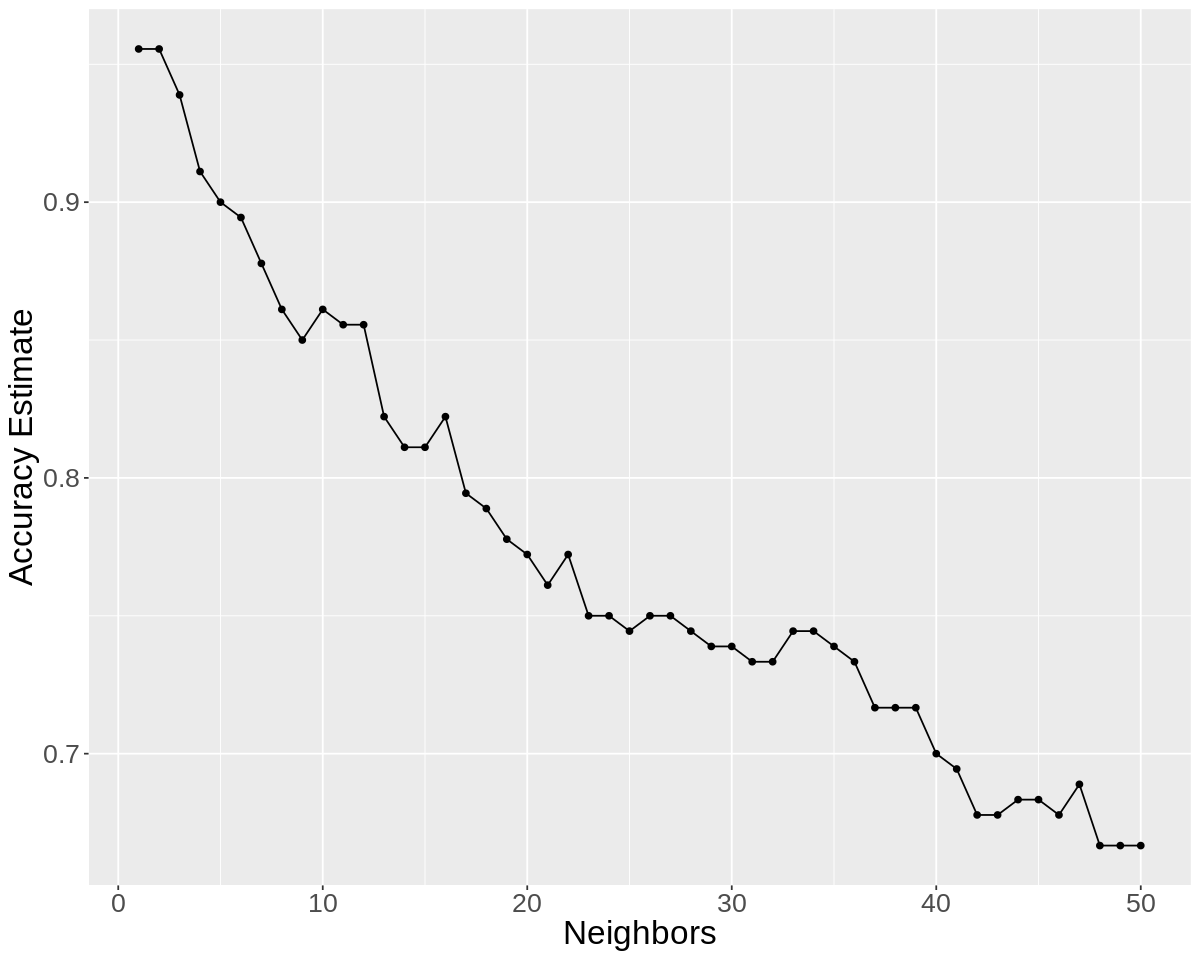

In [20]:
accuracies <- star_results %>%
filter(.metric == "accuracy")

accuracy_vs_k <- accuracies %>% 
ggplot(aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimate") +
theme(text = element_text(size = 20))

accuracy_vs_k

We can observe from the above plot that *K* = 1, 2 provides the highest accuracy. Therefore, we choose *K* = 2 as the best value of number of neighbors. Now, we will create a new model specification with *K* = 2, we call this new model specification `star_best_spec`. 

In [21]:
star_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>%
set_engine("kknn") %>%
set_mode("classification")

star_best_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 2
  weight_func = rectangular

Computational engine: kknn 


Then, we train the classifier with the training data `star_training` set using the `workflow` function, so we can bundle together the pre-processing, modeling, and post-processing requests. We name the workflow `star_fit`.

In [22]:
star_fit <- workflow() %>%
add_recipe(star_recipe) %>%
add_model(star_best_spec) %>%
fit(data = star_training)

star_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~2, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.07222222
Best kernel: rectangular
Best k: 2

Now we are ready to predict the class labels for our testing set. We pass the fitted model and the test dataset `star_testing` to the `predict` function. Then, we use the `bind_cols` function to add the column of predictions to the original test data. We call the predictions `star_predictions`.

In [23]:
star_predictions <- predict(star_fit, star_testing) %>%
bind_cols(star_testing)

head(star_predictions)
tail(star_predictions)

.pred_class,Temperature,A_M,Type
<fct>,<dbl>,<dbl>,<fct>
0,2600,18.70,0
0,2700,16.05,0
1,2799,14.79,1
1,3692,10.80,1
1,3192,13.53,1
2,16500,11.89,2


.pred_class,Temperature,A_M,Type
<fct>,<dbl>,<dbl>,<fct>
3,8250,-0.980,3
5,18734,-7.450,4
4,23095,-5.905,4
5,24145,-8.840,5
4,21904,-7.670,5
5,38940,-9.930,5


We also want to see our classifier's accuracy. So we use `metrics` function to help us. We input `Type` as the `truth` argument, and `.pred_class` as the `estimate` argument, then we `filter` the `accuracy` row to see the accuracy of our classifier. We call this object `star_test_predictions`.

We also want to see our classifier's accuracy. So we use `metrics` function to help us. We input `Type` as the truth argument, and `.pred_class` as the estimate argument, then we `filter` the accuracy row to see the accuracy of our classifier. We call this object `star_test_predictions`.

In [24]:
star_test_predictions <- star_predictions %>%
metrics(truth = Type, estimate = .pred_class) %>%
filter(.metric == "accuracy")

star_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9166667


As we can see, our classifier's accuracy is about 96.67%. We also want to look at the confusion matrix for the classifier, which shows us the table of predicted labels and correct labels. We perform this using `conf_mat` function, we need to specify the `truth` and `estimate` argument as we did in `metrics` function. We call this confusion matrix `star_mat`.

In [25]:
star_mat <- star_predictions %>%
conf_mat(truth = Type, estimate = .pred_class)

star_mat

          Truth
Prediction  0  1  2  3  4  5
         0 10  0  0  0  0  0
         1  0 10  0  0  0  0
         2  0  0 10  0  0  0
         3  0  0  0  9  1  0
         4  0  0  0  1  8  2
         5  0  0  0  0  1  8

# Discussion

As shown in the Methods and Results section, we used the k-nearest neighbor method and created a classification model to determine the star types of our testing data. As the result, the prediction accuracy for the testing data frame is about 96.67% based on our classifier. Then, the confusion matrix is generated to see details of our prediction. We expected the accuracy of the classifier to be larger than 80% when predicting the testing data frame. 96.67% satisfies and exceeds our expectations. As a result, our classifier is good for determining an unknown star’s type with a very high accuracy. Based on our project and its results, a future question could be: is it better if we use other variables (except temperature and absolute magnitude) to predict the star type to achieve better accuracy?

# References